# Import necessary libraries for data handling

In [1]:
import os
import numpy as np
import pandas as pd
from scipy.io import savemat
from tqdm import tqdm, trange  # For displaying progress bars
from copy import deepcopy
import syncopy as spy


Syncopy 2023.5

See https://syncopy.org for the online documentation.
For bug reports etc. please send an email to syncopy@esi-frankfurt.de



/cs/home/partodm/conda/alensdk310/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Logging to log directory '/cs/home/partodm/.spy/logs'.
Temporary storage directory set to '/cs/home/partodm/.spy/tmp_storage'.



# Import Allen SDK for accessing the EcephysProjectCache (electrophysiology data)

In [3]:
from allensdk.brain_observatory.ecephys.ecephys_project_cache import EcephysProjectCache

# Specify the path for the JSON manifest file (required by Allen SDK for file management)
# The data in the JSON file determines where downloaded data will be stored. See Allen SDK

In [4]:
manifest_path = os.path.join(os.path.curdir, 'manifest.json')
cache = EcephysProjectCache.from_warehouse(manifest=manifest_path)
sessions = cache.get_session_table()

# Define data parameters for the analysis

In [5]:
stimType = "flashes"  # 'flashes' 'drifting_gratings'  'gabors'
bipolar = 1  # 1:bipolar derivation   0:unipolar
sample_freq = 1250
sample_freq_rawdata = 30_000

# Select a session to analyze based on its index in the session table

In [6]:
sesnum = 7
ses_id = sessions.index.values[sesnum]
session = cache.get_session_data(ses_id)
probes = cache.get_probes()

# Retrieve presentation times for the specified stimulus type (Cut trials)

In [7]:
print(pd.unique(session.stimulus_presentations.stimulus_name))
presentation_table = session.stimulus_presentations[
    session.stimulus_presentations.stimulus_name == stimType]
presentation_times = presentation_table.start_time.values
presentation_ids = presentation_table.index.values
win = np.arange(-.25, .25, 1 / sample_freq) # Define time window around each stimulus presentation
stim_lbl = session.get_stimulus_table([stimType])['color'] # Get stimulus labels
prob_range = session.probes.index.values # Define range of probes in the session

['spontaneous' 'gabors' 'flashes' 'drifting_gratings' 'natural_movie_three'
 'natural_movie_one' 'static_gratings' 'natural_scenes']


# Read Allen data and save the spikes in Syncopy file format

In [9]:
def read_spy_spikes():
    """
    Function to extract spike data from Allen SDK, process it, and save it in Syncopy file format.
    """
    print("Creating Syncopy spike data file...")

    offset = -0.25 * sample_freq  # Offset in samples for each trial

    # first assemble units of interest based on firing rate 
    units_oi = []
    for prob_ind in tqdm(prob_range):
        units_oi += list(session.units[(session.units.probe_id == prob_ind) &
                                       (session.units.firing_rate > 10) &
                                       (session.units.nn_hit_rate > 0.95)].index)

    # Loop over trials for each stimulus presentation
    spy_spikes = []
    trldef_rows = []
    active_units = []
    for stim_time in tqdm(presentation_times):

        start = stim_time - 0.25
        stop = stim_time + 0.25

        # 2d array with columns: samples, channel, unit.
        # Channel is not given/interesting for spike data and has to be 0.
        channel_id = 0

        spy_trl = []

        for unit_idx, unit_id in enumerate(units_oi):

            unit_spike_times = session.spike_times[unit_id]
            # index time window
            bool_index = (unit_spike_times > start) & (unit_spike_times < stop)
            # relevant spikes in samples
            unit_spike_samples = (
                unit_spike_times[bool_index] + start) * sample_freq

            # Skip units without spikes in this window
            if unit_spike_samples.size == 0:
                continue

            active_units.append(unit_id)

            spy_trl.append(np.array([(sp_sample, channel_id, unit_idx) for
                                     sp_sample in unit_spike_samples], dtype=np.int64))

        spy_trl = np.vstack(spy_trl)
        spy_trl = spy_trl[spy_trl[:, 0].argsort()] # Sort spike samples by time
        spy_spikes.append(spy_trl)

        trldef_rows.append([spy_trl[0, 0], spy_trl[-1, 0], offset])

    trldef = np.vstack(trldef_rows)
    spy_spikes = spy.SpikeData(data=spy_spikes, samplerate=sample_freq)

    spy_spikes.trialdefinition = trldef
    # unit labels have to be strings
    spy_spikes.unit = list(map(str, set(active_units)))

    # Add custom metadata: raw sampling rate.
    spy_spikes.info['fsample_raw'] = sample_freq_rawdata

    # Finally save to disc.
    spy_spikes.save(os.path.join(
        os.path.curdir, 'allen_spike'), overwrite=True)
    # return Spikes

# Read Allen data and save the LFP data in Syncopy file format

In [10]:
def read_spy_lfp():
    """
    Function to extract LFP data, process it for each stimulus presentation, and save it in Syncopy file format.
    """
    print("Creating Syncopy LFP data file...")

    loc = []            # Channel locations
    ds = []             # LFP data for each trial
    twin = []           # Time windows for each trial
    lfps = []
    lfp_channel_id = [] # Channel IDs for bipolar or unipolar data

    # Attempt to retrieve LFP data for each probe
    for prob_ind in tqdm(prob_range):
        try:
            lfps.append(session.get_lfp(prob_ind))
        except:
            print(f"No LFP in this electrode:{prob_range}")
            continue

    for tr in trange(len(presentation_times)):
        lfp_buf = [] # Buffer to store LFP data for the current trial

        # Append LFP of all channels
        for _, lfp in enumerate(lfps):
            ch_range = lfp.channel.values
            for z in range(len(ch_range)):
                channel_ids = ch_range[z]
                try:
                    # Retrieve bipolar or unipolar LFP data depending on the parameter set
                    if bipolar == 1:
                        lfp_tmp = (lfp.sel(time=(presentation_times[tr]+win), method='nearest', channel=ch_range[z]))-(
                            lfp.sel(time=(presentation_times[tr]+win), method='nearest', channel=ch_range[z+1]))
                        loc_tmp = (
                            session.channels.ecephys_structure_acronym[channel_ids])
                    elif bipolar == 0:
                        lfp_tmp = (lfp.sel(
                            time=(presentation_times[tr]+win), method='nearest', channel=channel_ids))
                        loc_tmp = (
                            session.channels.ecephys_structure_acronym[channel_ids])

                    if tr == 0:
                        loc.append(loc_tmp)
                        if bipolar == 1:
                            lfp_channel_id.append([ch_range[z], ch_range[z+1]])
                        elif bipolar == 0:
                            lfp_channel_id.append(channel_ids)
                    lfp_buf.append(lfp_tmp)
                    lfp_buf[-1] = np.nan_to_num(
                        lfp_buf[-1].values.reshape(1, -1))
                except:
                    pass

        ds.append(np.concatenate(lfp_buf, axis=0).T)
        twin.append(deepcopy(win))

    # Put data into Syncopy objects.
    lfp = spy.AnalogData(data=ds, samplerate=sample_freq)
    lfp.info['Label'] = loc
    lfp.info['stim_lbl'] = list(stim_lbl)
    lfp.info['Twin'] = [arr.tolist() for arr in twin]

    # Finally save to disc.
    lfp.save(os.path.join(os.path.curdir, 'allen_lfp'), overwrite=True)
    # return LFP

# Read Allen data and save data in Fieldtrip-compatible (MATLAB) format

In [11]:
def read_ft():
    """
    Function to extract both spike and LFP data, process it, and save it in Fieldtrip-compatible format.
    """
    print("Creating Fieldtrip data file...")

    spikes = []
    loc = []
    locspk = []
    ds = []
    ds_spk = []
    twin = []
    lfps = []
    spk_channel_id = []
    lfp_channel_id = []

    fieldtrip = {"Label": [],  # cell(1*chNum)
                 "Labelspk": [],
                 "chIDlfp": [],
                 "chIDspk": [],
                 "trialinfo": {},  # double(trialNum*info)
                 "trial": [],          # cell(1*trialNum) >> (chNum*sample)
                 "trial_spike": [],
                 "time": [],           # cell(1*trialNum) >> (1*sample)
                 "fsample": sample_freq,        # sampling rate  1250
                 "fsample_raw": sample_freq_rawdata,
                 # 1*1 structure (other infor) >> not necessary
                 "cfg": []
                 }

    # Append spikes of all channels
    for prob_ind in tqdm(prob_range):
        try:
            lfps.append(session.get_lfp(prob_ind))
        except:
            continue
        units_of_interest = (session.units[(session.units.probe_id == prob_ind) &
                                           (session.units.firing_rate > 10) &
                                           (session.units.nn_hit_rate > 0.95)])
        for i in range(len(units_of_interest)):
            unit_id = units_of_interest.index.values[i]
            channel_index = units_of_interest .loc[unit_id].probe_channel_number
            spk_channel_id.append(session.channels[(session.channels.probe_channel_number == channel_index) &
                                                   (session.channels.probe_id == prob_ind)].index.values[0])
            spikes.append(session.spike_times[unit_id])

    for tr in trange(len(presentation_times)):
        lfp_buf = []
        spk_buf = []
        for unitNum in range(len(spikes)):
            tmp = np.zeros(len(win))
            sp = (spikes[unitNum][(spikes[unitNum] > presentation_times[tr]+win[0]) &
                                  (spikes[unitNum] < presentation_times[tr]+win[-1])])-(presentation_times[tr]+win[0])
            for i in sp:
                tmp[int(i*fieldtrip['fsample'])] = 1
            spk_buf.append(tmp)
            if tr == 0:
                locspk.append(
                    session.channels.ecephys_structure_acronym[spk_channel_id[unitNum]])

        # Append LFP of all channels
        for _, lfp in enumerate(lfps):
            ch_range = lfp.channel.values
            for z in range(len(ch_range)):
                channel_ids = ch_range[z]
                try:
                    if bipolar == 1:
                        lfp_tmp = (lfp.sel(time=(presentation_times[tr]+win), method='nearest', channel=ch_range[z]))-(
                            lfp.sel(time=(presentation_times[tr]+win), method='nearest', channel=ch_range[z+1]))
                        loc_tmp = (
                            session.channels.ecephys_structure_acronym[channel_ids])
                    elif bipolar == 0:
                        lfp_tmp = (lfp.sel(
                            time=(presentation_times[tr]+win), method='nearest', channel=channel_ids))
                        loc_tmp = (
                            session.channels.ecephys_structure_acronym[channel_ids])
                    if tr == 0:
                        loc.append(loc_tmp)
                        if bipolar == 1:
                            lfp_channel_id.append([ch_range[z], ch_range[z+1]])
                        elif bipolar == 0:
                            lfp_channel_id.append(channel_ids)
                    lfp_buf.append(lfp_tmp)
                    lfp_buf[-1] = np.nan_to_num(
                        lfp_buf[-1].values.reshape(1, -1))
                except:
                    pass

        ds.append(np.concatenate(lfp_buf, axis=0).T)
        print(ds[-1].shape)
        twin.append(deepcopy(win))
        ds_spk.append(list(map(list, zip(*spk_buf))))
    
    # Save the data in Fieldtrip-compatible format
    fieldtrip["trial"] = ds
    fieldtrip["spike"] = ds_spk
    fieldtrip["Label"] = loc
    fieldtrip["Labelspk"] = locspk
    fieldtrip["time"] = twin
    fieldtrip["trialinfo"] = {'stim_lbl': stim_lbl,
                              'chIDlfp': lfp_channel_id,
                              'chIDspk': spk_channel_id
                              }
    fieldtrip2 = deepcopy(fieldtrip)
    fieldtrip2["trialinfo"] = []
    fieldtrip2["stim_lbl"] = list(stim_lbl)

    savemat(os.path.join(os.path.curdir, 'allen_FT.mat'), fieldtrip2)

# Execute the functions if running as a script
if __name__ == "__main__":
    read_spy_spikes()
    read_spy_lfp()
    read_ft()

Creating Syncopy spike data file...


100%|██████████| 150/150 [00:13<00:00, 11.39it/s]


Creating Syncopy LFP data file...


100%|██████████| 150/150 [50:22<00:00, 20.15s/it]


Creating Fieldtrip data file...


  1%|          | 1/150 [00:28<1:10:11, 28.27s/it]

(625, 417)


  1%|▏         | 2/150 [00:48<57:55, 23.48s/it]  

(625, 417)


  2%|▏         | 3/150 [01:08<53:49, 21.97s/it]

(625, 417)


  3%|▎         | 4/150 [01:28<51:46, 21.28s/it]

(625, 417)


  3%|▎         | 5/150 [01:48<50:28, 20.88s/it]

(625, 417)


  4%|▍         | 6/150 [02:09<49:31, 20.64s/it]

(625, 417)


  5%|▍         | 7/150 [02:29<48:50, 20.50s/it]

(625, 417)


  5%|▌         | 8/150 [02:49<48:16, 20.40s/it]

(625, 417)


  6%|▌         | 9/150 [03:09<47:48, 20.34s/it]

(625, 417)


  7%|▋         | 10/150 [03:29<47:22, 20.30s/it]

(625, 417)


  7%|▋         | 11/150 [03:50<46:59, 20.28s/it]

(625, 417)


  8%|▊         | 12/150 [04:10<46:35, 20.26s/it]

(625, 417)


  9%|▊         | 13/150 [04:30<46:17, 20.27s/it]

(625, 417)


  9%|▉         | 14/150 [04:51<46:05, 20.34s/it]

(625, 417)


 10%|█         | 15/150 [05:11<45:54, 20.40s/it]

(625, 417)


 11%|█         | 16/150 [05:32<45:38, 20.44s/it]

(625, 417)


 11%|█▏        | 17/150 [05:53<45:31, 20.54s/it]

(625, 417)


 12%|█▏        | 18/150 [06:13<45:10, 20.54s/it]

(625, 417)


 13%|█▎        | 19/150 [06:34<44:48, 20.52s/it]

(625, 417)


 13%|█▎        | 20/150 [06:54<44:34, 20.57s/it]

(625, 417)


 14%|█▍        | 21/150 [07:15<44:12, 20.56s/it]

(625, 417)


 15%|█▍        | 22/150 [07:35<43:49, 20.54s/it]

(625, 417)


 15%|█▌        | 23/150 [07:56<43:23, 20.50s/it]

(625, 417)


 16%|█▌        | 24/150 [08:16<42:54, 20.44s/it]

(625, 417)


 17%|█▋        | 25/150 [08:36<42:29, 20.40s/it]

(625, 417)


 17%|█▋        | 26/150 [08:57<42:07, 20.39s/it]

(625, 417)


 18%|█▊        | 27/150 [09:17<41:43, 20.35s/it]

(625, 417)


 19%|█▊        | 28/150 [09:37<41:20, 20.33s/it]

(625, 417)


 19%|█▉        | 29/150 [09:58<41:03, 20.36s/it]

(625, 417)


 20%|██        | 30/150 [10:18<40:44, 20.37s/it]

(625, 417)


 21%|██        | 31/150 [10:38<40:24, 20.38s/it]

(625, 417)


 21%|██▏       | 32/150 [10:59<40:06, 20.40s/it]

(625, 417)


 22%|██▏       | 33/150 [11:19<39:54, 20.46s/it]

(625, 417)


 23%|██▎       | 34/150 [11:40<39:27, 20.41s/it]

(625, 417)


 23%|██▎       | 35/150 [12:00<39:04, 20.39s/it]

(625, 417)


 24%|██▍       | 36/150 [12:20<38:40, 20.36s/it]

(625, 417)


 25%|██▍       | 37/150 [12:41<38:16, 20.32s/it]

(625, 417)


 25%|██▌       | 38/150 [13:01<37:57, 20.34s/it]

(625, 417)


 26%|██▌       | 39/150 [13:21<37:34, 20.31s/it]

(625, 417)


 27%|██▋       | 40/150 [13:42<37:13, 20.30s/it]

(625, 417)


 27%|██▋       | 41/150 [14:02<36:54, 20.32s/it]

(625, 417)


 28%|██▊       | 42/150 [14:22<36:32, 20.30s/it]

(625, 417)


 29%|██▊       | 43/150 [14:42<36:13, 20.31s/it]

(625, 417)


 29%|██▉       | 44/150 [15:03<35:53, 20.32s/it]

(625, 417)


 30%|███       | 45/150 [15:23<35:35, 20.33s/it]

(625, 417)


 31%|███       | 46/150 [15:43<35:13, 20.32s/it]

(625, 417)


 31%|███▏      | 47/150 [16:04<34:52, 20.32s/it]

(625, 417)


 32%|███▏      | 48/150 [16:24<34:31, 20.31s/it]

(625, 417)


 33%|███▎      | 49/150 [16:44<34:10, 20.30s/it]

(625, 417)


 33%|███▎      | 50/150 [17:05<33:59, 20.40s/it]

(625, 417)


 34%|███▍      | 51/150 [17:25<33:37, 20.38s/it]

(625, 417)


 35%|███▍      | 52/150 [17:46<33:15, 20.36s/it]

(625, 417)


 35%|███▌      | 53/150 [18:06<32:53, 20.35s/it]

(625, 417)


 36%|███▌      | 54/150 [18:26<32:32, 20.34s/it]

(625, 417)


 37%|███▋      | 55/150 [18:47<32:11, 20.33s/it]

(625, 417)


 37%|███▋      | 56/150 [19:07<31:51, 20.34s/it]

(625, 417)


 38%|███▊      | 57/150 [19:27<31:30, 20.33s/it]

(625, 417)


 39%|███▊      | 58/150 [19:48<31:10, 20.33s/it]

(625, 417)


 39%|███▉      | 59/150 [20:08<30:51, 20.34s/it]

(625, 417)


 40%|████      | 60/150 [20:28<30:30, 20.33s/it]

(625, 417)


 41%|████      | 61/150 [20:49<30:34, 20.61s/it]

(625, 417)


 41%|████▏     | 62/150 [21:11<30:31, 20.81s/it]

(625, 417)


 42%|████▏     | 63/150 [21:32<30:20, 20.93s/it]

(625, 417)


 43%|████▎     | 64/150 [21:53<29:50, 20.82s/it]

(625, 417)


 43%|████▎     | 65/150 [22:13<29:17, 20.68s/it]

(625, 417)


 44%|████▍     | 66/150 [22:33<28:48, 20.57s/it]

(625, 417)


 45%|████▍     | 67/150 [22:54<28:21, 20.49s/it]

(625, 417)


 45%|████▌     | 68/150 [23:14<27:56, 20.44s/it]

(625, 417)


 46%|████▌     | 69/150 [23:34<27:33, 20.41s/it]

(625, 417)


 47%|████▋     | 70/150 [23:54<27:10, 20.38s/it]

(625, 417)


 47%|████▋     | 71/150 [24:15<26:49, 20.37s/it]

(625, 417)


 48%|████▊     | 72/150 [24:35<26:26, 20.33s/it]

(625, 417)


 49%|████▊     | 73/150 [24:55<26:05, 20.33s/it]

(625, 417)


 49%|████▉     | 74/150 [25:16<25:45, 20.33s/it]

(625, 417)


 50%|█████     | 75/150 [25:37<25:48, 20.64s/it]

(625, 417)


 51%|█████     | 76/150 [25:57<25:20, 20.54s/it]

(625, 417)


 51%|█████▏    | 77/150 [26:18<24:55, 20.49s/it]

(625, 417)


 52%|█████▏    | 78/150 [26:38<24:34, 20.47s/it]

(625, 417)


 53%|█████▎    | 79/150 [26:59<24:11, 20.44s/it]

(625, 417)


 53%|█████▎    | 80/150 [27:19<23:48, 20.41s/it]

(625, 417)


 54%|█████▍    | 81/150 [27:41<24:00, 20.87s/it]

(625, 417)


 55%|█████▍    | 82/150 [28:03<24:03, 21.23s/it]

(625, 417)


 55%|█████▌    | 83/150 [28:23<23:25, 20.98s/it]

(625, 417)


 56%|█████▌    | 84/150 [28:44<22:51, 20.78s/it]

(625, 417)


 57%|█████▋    | 85/150 [29:04<22:21, 20.64s/it]

(625, 417)


 57%|█████▋    | 86/150 [29:24<21:54, 20.54s/it]

(625, 417)


 58%|█████▊    | 87/150 [29:45<21:28, 20.46s/it]

(625, 417)


 59%|█████▊    | 88/150 [30:05<21:04, 20.40s/it]

(625, 417)


 59%|█████▉    | 89/150 [30:25<20:41, 20.36s/it]

(625, 417)


 60%|██████    | 90/150 [30:45<20:20, 20.34s/it]

(625, 417)


 61%|██████    | 91/150 [31:06<19:57, 20.30s/it]

(625, 417)


 61%|██████▏   | 92/150 [31:26<19:37, 20.30s/it]

(625, 417)


 62%|██████▏   | 93/150 [31:46<19:16, 20.29s/it]

(625, 417)


 63%|██████▎   | 94/150 [32:06<18:56, 20.29s/it]

(625, 417)


 63%|██████▎   | 95/150 [32:27<18:36, 20.29s/it]

(625, 417)


 64%|██████▍   | 96/150 [32:47<18:15, 20.30s/it]

(625, 417)


 65%|██████▍   | 97/150 [33:07<17:55, 20.30s/it]

(625, 417)


 65%|██████▌   | 98/150 [33:28<17:35, 20.29s/it]

(625, 417)


 66%|██████▌   | 99/150 [33:48<17:15, 20.30s/it]

(625, 417)


 67%|██████▋   | 100/150 [34:08<16:54, 20.29s/it]

(625, 417)


 67%|██████▋   | 101/150 [34:28<16:34, 20.29s/it]

(625, 417)


 68%|██████▊   | 102/150 [34:49<16:14, 20.29s/it]

(625, 417)


 69%|██████▊   | 103/150 [35:09<15:53, 20.29s/it]

(625, 417)


 69%|██████▉   | 104/150 [35:29<15:33, 20.30s/it]

(625, 417)


 70%|███████   | 105/150 [35:50<15:13, 20.30s/it]

(625, 417)


 71%|███████   | 106/150 [36:10<14:53, 20.30s/it]

(625, 417)


 71%|███████▏  | 107/150 [36:30<14:32, 20.30s/it]

(625, 417)


 72%|███████▏  | 108/150 [36:51<14:12, 20.29s/it]

(625, 417)


 73%|███████▎  | 109/150 [37:11<13:51, 20.28s/it]

(625, 417)


 73%|███████▎  | 110/150 [37:31<13:30, 20.27s/it]

(625, 417)


 74%|███████▍  | 111/150 [37:51<13:10, 20.27s/it]

(625, 417)


 75%|███████▍  | 112/150 [38:12<12:50, 20.27s/it]

(625, 417)


 75%|███████▌  | 113/150 [38:32<12:29, 20.26s/it]

(625, 417)


 76%|███████▌  | 114/150 [38:52<12:09, 20.28s/it]

(625, 417)


 77%|███████▋  | 115/150 [39:12<11:49, 20.27s/it]

(625, 417)


 77%|███████▋  | 116/150 [39:33<11:28, 20.26s/it]

(625, 417)


 78%|███████▊  | 117/150 [39:53<11:09, 20.27s/it]

(625, 417)


 79%|███████▊  | 118/150 [40:13<10:48, 20.27s/it]

(625, 417)


 79%|███████▉  | 119/150 [40:33<10:28, 20.27s/it]

(625, 417)


 80%|████████  | 120/150 [40:54<10:08, 20.29s/it]

(625, 417)


 81%|████████  | 121/150 [41:14<09:48, 20.28s/it]

(625, 417)


 81%|████████▏ | 122/150 [41:34<09:27, 20.26s/it]

(625, 417)


 82%|████████▏ | 123/150 [41:55<09:07, 20.26s/it]

(625, 417)


 83%|████████▎ | 124/150 [42:15<08:46, 20.25s/it]

(625, 417)


 83%|████████▎ | 125/150 [42:35<08:26, 20.24s/it]

(625, 417)


 84%|████████▍ | 126/150 [42:55<08:06, 20.25s/it]

(625, 417)


 85%|████████▍ | 127/150 [43:15<07:45, 20.24s/it]

(625, 417)


 85%|████████▌ | 128/150 [43:36<07:25, 20.23s/it]

(625, 417)


 86%|████████▌ | 129/150 [43:56<07:05, 20.25s/it]

(625, 417)


 87%|████████▋ | 130/150 [44:16<06:45, 20.26s/it]

(625, 417)


 87%|████████▋ | 131/150 [44:37<06:24, 20.26s/it]

(625, 417)


 88%|████████▊ | 132/150 [44:57<06:04, 20.26s/it]

(625, 417)


 89%|████████▊ | 133/150 [45:17<05:44, 20.25s/it]

(625, 417)


 89%|████████▉ | 134/150 [45:37<05:24, 20.26s/it]

(625, 417)


 90%|█████████ | 135/150 [45:58<05:04, 20.27s/it]

(625, 417)


 91%|█████████ | 136/150 [46:18<04:43, 20.25s/it]

(625, 417)


 91%|█████████▏| 137/150 [46:38<04:23, 20.24s/it]

(625, 417)


 92%|█████████▏| 138/150 [46:58<04:03, 20.25s/it]

(625, 417)


 93%|█████████▎| 139/150 [47:18<03:42, 20.24s/it]

(625, 417)


 93%|█████████▎| 140/150 [47:39<03:22, 20.23s/it]

(625, 417)


 94%|█████████▍| 141/150 [47:59<03:02, 20.23s/it]

(625, 417)


 95%|█████████▍| 142/150 [48:19<02:41, 20.21s/it]

(625, 417)


 95%|█████████▌| 143/150 [48:39<02:21, 20.21s/it]

(625, 417)


 96%|█████████▌| 144/150 [49:00<02:01, 20.30s/it]

(625, 417)


 97%|█████████▋| 145/150 [49:20<01:41, 20.26s/it]

(625, 417)


 97%|█████████▋| 146/150 [49:40<01:20, 20.24s/it]

(625, 417)


 98%|█████████▊| 147/150 [50:00<01:00, 20.22s/it]

(625, 417)


 99%|█████████▊| 148/150 [50:21<00:40, 20.22s/it]

(625, 417)


 99%|█████████▉| 149/150 [50:41<00:20, 20.22s/it]

(625, 417)


100%|██████████| 150/150 [51:01<00:00, 20.41s/it]

(625, 417)


# Time-lock raster plot and peri-stimulus time histogram of spiking activity

# Import necessary libraries for data handling

In [13]:
import syncopy as spy
import matplotlib.pyplot as plt

# set parameters and load spike data

In [14]:
plt.rcParams['pdf.fonttype'] = 42
saveFig = 1             # 0:not savefigs  1: save figs
spikeData = spy.load('allen_spike.spy')
data_spk = spikeData.trials
samplerate = 1250
offset = -0.25 * samplerate  # Offset in samples for aligning samples to stimulus onset.

# Raster plot

<Figure size 640x480 with 0 Axes>

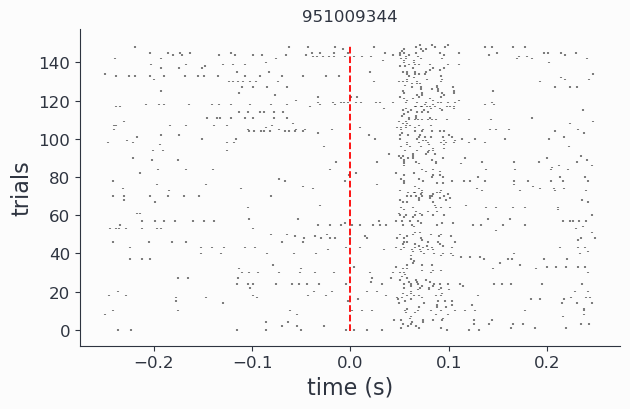

In [15]:
unitID = '951009344'
unitname = 'unit30'
plt.close('all')
plt.figure()
spikeData.singlepanelplot(unit=unitID)

if saveFig == 1:
    plt.savefig("Raster.png")
    plt.savefig("Raster.pdf")

# PSTH

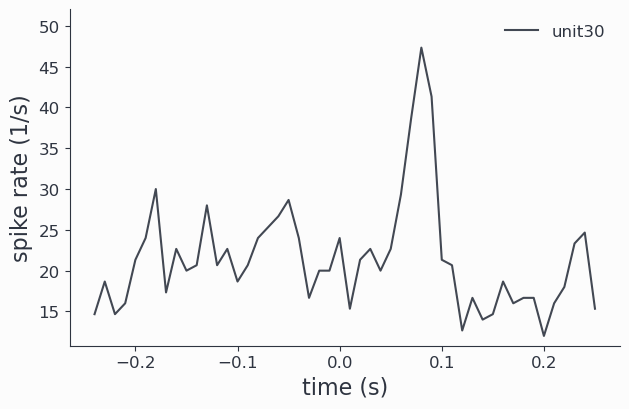

In [16]:
cfg = spy.StructDict()
cfg.latency = "minperiod"  # to avoid NaNs
cfg.output = "rate"
cfg.binsize = 0.01  # in seconds
spike_rate = spy.spike_psth(spikeData, cfg)

# Remove channel0 from channel names.
chan_names = [old_name.split('_')[1] for old_name in spike_rate.channel]
spike_rate.channel = chan_names

# Compute the mean.
rate_trl_mean = spy.mean(spike_rate, dim='trials')

# Plot.
fig, ax = rate_trl_mean.singlepanelplot(channel=unitname)
ax.set_ylabel('spike rate (1/s)')
fig.tight_layout()

if saveFig == 1:
    plt.savefig("PSTH.png")
    plt.savefig("PSTH.pdf")

# Power spectrum of LFP

# Import necessary libraries for data handling

In [17]:
import pickle
import numpy as np
import syncopy as spy
import matplotlib.pyplot as plt

# set parameters and load LFP data

In [18]:
# Parameters
plt.rcParams['pdf.fonttype'] = 42
saveFig = 1             # 0:not savefigs  1: save figs
freq_range = [15, 90]   # frequency range
fs = 1250               # sampling rate
areas = {
    "V1L": ['VISl'],
    "V1RL": ['VISrl'],
    "Thal-MG": ['MGv'],
    "Thal-LP": ['LP']
}

# Load data
lfpdata = spy.load('allen_lfp.spy')

# Power estimation

11:43:28 - WARNING: Syncopy <process_taper> WARNING: `nTaper` is only used for multi-tapering!
11:43:30 - WARNING: Syncopy <process_taper> WARNING: `nTaper` is only used for multi-tapering!


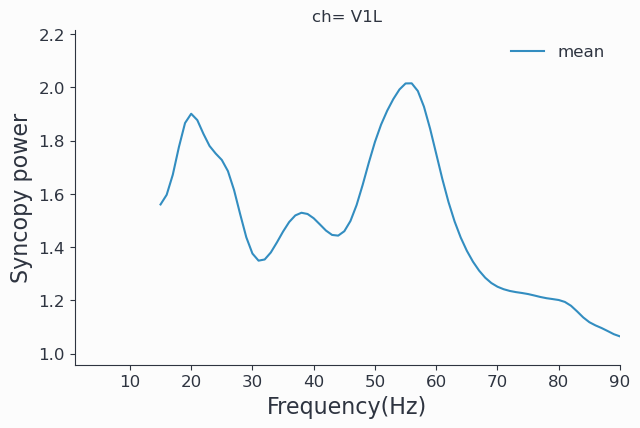

In [19]:
# select stimulus and baseline epochs for analysis
L = len(lfpdata.time[0])
base_time = np.arange(0, np.ceil(L/2)-1, 1)
stim_time = np.arange(np.floor(L/2), L-1, 1)
TW_base = [lfpdata.time[0][int(base_time[0])],
           lfpdata.time[0][int(base_time[-1])]]
TW_stim = [lfpdata.time[0][int(stim_time[0])],
           lfpdata.time[0][int(stim_time[-1])]]
data_base = lfpdata.selectdata(latency=TW_base)
data_stim = lfpdata.selectdata(latency=TW_stim)

# Initialize configuration settings for Syncopy power analysis
cfg = []
cfg = spy.get_defaults(spy.freqanalysis)
cfg.method = 'mtmfft'
cfg.output = 'pow'
cfg.pad = 1
cfg.taper = 'hann'
cfg.nTaper = 1
cfg.keeptrials = True
cfg.foilim = freq_range

# Baseline correction
psd_stim = spy.freqanalysis(cfg, data_stim)
psd_base = spy.freqanalysis(cfg, data_base)
psd = []
psd2 = []
psd = psd_stim
powbs = (np.mean(psd_base.data, axis=0))
psd.data = psd_stim.data/powbs
selectch = np.arange(0, len(psd.channel), 1)
pow = psd.data

# Outlier detection
outl = np.nanmean(np.nanmean(pow, axis=2), axis=0) > (np.nanmean(
    np.reshape(pow, (1, -1)), axis=1)+3*np.std(np.reshape(pow, (1, -1)), axis=1))
indices = np.where(outl)[0]
selch = np.delete(selectch, indices)
spy.selectdata(psd, channel=list(lfpdata.channel[selch]))

cfg = spy.StructDict()
psd2 = spy.selectdata(cfg, psd)

# Grand power
channelLBL = lfpdata.info['Label']
GrandPSD = spy.mean(psd2, dim='trials')
iter = 1
Pow = []

# for area_iter in areas.keys():
area_iter = list(areas.keys())[0]
area = []
y = []
y_tmp = []
indexes = []
for i in areas[f"{area_iter}"]:
    indexes.append([index for index in range(
        len(channelLBL)) if channelLBL[index] == i])
chindx = list(map(int, np.concatenate(indexes)))

y_tmp = spy.selectdata(GrandPSD, channel=chindx)
y = spy.mean(y_tmp, dim='channel')
fig, ax = y.singlepanelplot(logscale=False)
ax.set_title(f"ch= {area_iter}")
ax.set_xlabel('Frequency(Hz)')
ax.set_ylabel('Syncopy power')
ax.set_xlim([1, 90])
Pow.append(np.squeeze(y.data))
iter = iter+1

if saveFig == 1:
    plt.savefig(f'power{area_iter}.png')
    plt.savefig(f'power{area_iter}.pdf')

pickle.dump(Pow, open(f"SavedData/PyPow.plk", "wb"))

# Connectivity analysis

# Import necessary libraries for data handling

In [20]:
import pickle
import numpy as np
import syncopy as spy
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter

# set parameters and load LFP data

In [21]:
plt.rcParams['pdf.fonttype'] = 42
cohppcGC = 1  # 1: coh  2:ppc 3:GC
saveFig = 1             # 0:not savefigs  1: save figs
freq_range = [1, 100]   # frequency range
fs = 1250               # sampling rate
areas = {
    "V1L": ['VISl'],
    "V1RL": ['VISrl'],
    "Thal-MG": ['MGv'],
    "Thal-LP": ['LP']
}

# Load data
lfpdata = spy.load('allen_lfp.spy')
channelLBL = lfpdata.info['Label']

#  connectivity estimation

220
220
220
220
220
220
220
220
220
220
220
220
220
220
220
220
220
220
220
220
220
220
220
220
220
220
220
220
220
220
220
220
220
220
220
220
220
220
220
220
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
222
222
222
222
222
222
222
222
222
222
222
222
222
222
222
222
222
222
222
222
222
222
222
222
222
222
222
222
222
222
222
222
222
222
222
222
222
222
222
222
223
223
223
223
223
223
223
223
223
223
223
223
223
223
223
223
223
223
223
223
223
223
223
223
223
223
223
223
223
223
223
223
223
223
223
223
223
223
223
223
224
224
224
224
224
224
224
224
224
224
224
224
224
224
224
224
224
224
224
224
224
224
224
224
224
224
224
224
224
224
224
224
224
224
224
224
224
224
224
224
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
226
226
226
226
226
226
226
226
226
226


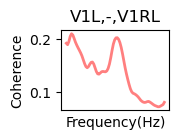

In [22]:
L = len(lfpdata.time[0]) # Length of the time series for LFP data
stim_time = np.arange(np.floor(L/2), L-1, 1) # Define stimulus time range
TW_stim = [lfpdata.time[0][int(stim_time[0])],
           lfpdata.time[0][int(stim_time[-1])]] # Define time window for analysis
data_stim_all = lfpdata.selectdata(latency=TW_stim)  # Select data within the specified time window for analysis


# Initialize configuration settings for Syncopy connectivity analysis
cfg = []
cfg = spy.StructDict()
if cohppcGC == 1:
    cfg.method = 'coh' # Coherence method
elif cohppcGC == 2:
    cfg.method = 'ppc' # Pairwise phase consistency
elif cohppcGC == 3:
    cfg.method = 'granger'  # Granger causality
    np.seterr(divide='ignore', invalid='ignore')

cfg.pad = 1  # 'maxperlen'     # Padding applied to time series
# Optional configuration settings for spectral analysis (tapering and smoothing)
# cfg.taper = 'None' #'hann'  # 'dpss' 'hann'
# cfg.nTaper = 1
# cfg.tapsmofrq = 3

# Loop over defined brain areas and their channels to compute connectivity
area_num = list(areas.keys())
plt.close('all')
plt.figure()
iter = 0

# Iterate over pairs of areas (sender and receiver) to calculate connectivity metrics
for sender in range(0, 1):  # range(len(area_num)):  # -1    # Iterate over each sender area
    for receiver in range(1, 2):  # range(len(area_num)):  # sender+1,    # Iterate over each receiver area
        iter = iter+1
        if receiver > sender:
            # For each sender and receiver pair, find and analyze relevant channels
            for sender_ch in areas[area_num[sender]]:
                for receiver_ch in areas[area_num[receiver]]:
                    Con12 = []  # Storage for sender-to-receiver connectivity
                    Con21 = []  # Storage for receiver-to-sender connectivity
                    ch1 = []  # Lists to hold the channel indices
                    ch2 = []
                    ppc_val = []  # PPC and feedback PPC values
                    ppc_val_FB = []
                    
                    # Find indices for the channels based on the labels
                    for index, item in enumerate(channelLBL):
                        if item == sender_ch:
                            ch1.append(index)
                        if item == receiver_ch:
                            ch2.append(index)
                    # ch1 = np.nonzero(channelLBL == sender_ch)[0]
                    # ch2 = np.nonzero(channelLBL == receiver_ch)[0]

                    # Iterate over channel combinations for sender and receiver
                    for c1 in ch1:
                        for c2 in ch2:
                            print(c1)
                            chsV1V2 = np.concatenate((c1, c2), axis=None)
                            data_stim_subGroup = spy.selectdata(
                                data_stim_all, channel=chsV1V2)
                            
                            # Perform connectivity analysis based on method specified in cfg
                            ppc = spy.connectivityanalysis(
                                data_stim_subGroup, cfg)
                            fr = np.where((ppc.freq >= 15) &
                                          (ppc.freq <= 90))[0]
                            fr = fr+1

                            # Identify sender and receiver indices within channel pair
                            c11 = []
                            c22 = []
                            for index, item in enumerate(chsV1V2):
                                if channelLBL[item] == sender_ch:
                                    c11.append(index)
                                if channelLBL[item] == receiver_ch:
                                    c22.append(index)
                            # ppc_val = spy.selectdata(ppc, frequency=[min(fr), max(fr)], channel_i=c11, channel_j=c22)
                            tmp1 = ppc.data[0]
                            tmp2 = tmp1[fr, c11, c22]
                            Con12.append(tmp2)
                            # # Con12.append(np.squeeze(ppc_val.data))

                            # If method is Granger causality, also calculate feedback direction
                            if cohppcGC == 3:
                                ppc_val_FB = spy.selectdata(
                                    ppc, frequency=[min(fr), max(fr)], channel_i=c22, channel_j=c11)
                                # # Con21.append(np.squeeze(ppc_val_FB.data))
                                tmp1 = []
                                tmp2 = []
                                tmp1 = ppc.data[0]
                                tmp2 = tmp1[fr, c22, c11]
                                Con21.append(tmp2)
                    
                    # Plotting connectivity values
                    print(sender, receiver)
                    plt.subplot(4, 4, iter)
                    plt.plot(np.squeeze(np.nanmean(Con12, axis=0)), '-',
                             lw=2, c='red', alpha=0.5)
                    if cohppcGC == 3:
                        plt.plot(np.squeeze(np.nanmean(Con21, axis=0)),
                                 '--', lw=2, c='red', alpha=0.5)
                        plt.title(
                            f"__{area_num[sender]}->{area_num[receiver]}")
                    else:
                        plt.title(f"{area_num[sender]},-,{area_num[receiver]}")

                    plt.xticks([], [])
                    if iter == 1:
                        plt.xlabel('Frequency(Hz)')
                        if cohppcGC == 1:
                            plt.ylabel('Coherence')
                        elif cohppcGC == 2:
                            plt.ylabel('PPC')
                        elif cohppcGC == 3:
                            plt.ylabel('GC')
                    if saveFig == 1:
                        plt.savefig(f'coh_ppc_gc_{cohppcGC}.png')
                        plt.savefig(f'coh_ppc_gc_{cohppcGC}.pdf')

# Compile connectivity results into a dictionary and save to a file
Con = {'fr': fr,
       'Con12': Con12,
       'Con21': Con21,
       }

pickle.dump(Con, open(f"SavedData/PyCohPpcGC{cohppcGC}.plk", "wb"))